In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#data = pd.read_csv('ASL_master.csv')
#data_small= data[["Species", "sampleYear", "sampleDate", "Length", "Weight", "Sex", 
#                "Salt.Water.Age", "Fresh.Water.Age", "Lat", "Lon", "DistrictID", "Sub.DistrictID", "Flag"]]
data_small = pd.read_csv('ASL_master.csv', usecols = ["Species", "sampleYear", "Length"])
data_small.columns

Index(['Species', 'sampleYear', 'Length'], dtype='object')

In [1]:
#find the % of entries that are nan for each column
data_small.isna().sum()/data_small.shape[0]

NameError: name 'data_small' is not defined

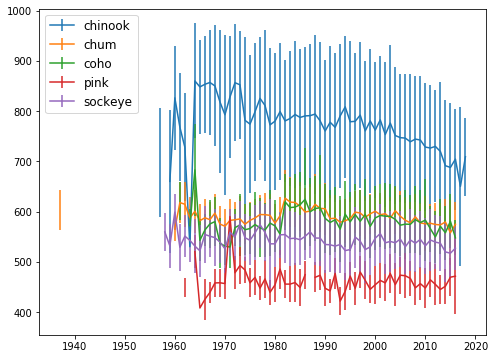

In [130]:
speciesbyyear = data_small.groupby(["sampleYear", "Species"])
meanbyyear = speciesbyyear['Length'].mean()
stdbyyear = speciesbyyear['Length'].std()
df_mean = meanbyyear.unstack()
df_std = stdbyyear.unstack()

fig, ax = plt.subplots(figsize=(8,6))
for s in data_small['Species'].unique():
    ax.errorbar(df_mean[s].index, df_mean[s].values, label = s, yerr=df_std[s].values)
ax.legend(loc=2, fontsize = 12)